---
> Created 10.20.2019 by Mike Schmidt as an exploration and comparison with Angus Campbell's independent code looking at the same things.

> Updated 10.26.2019 to order Gandal's genes by absolute value of log-2-fold-change, and import multiple lists for comparison.

> Updated 11/17/2019 to avoid throwing away good data too early (and match Angus's code which keeps all data possible).

> Updated 11/27/2019 to replace entrez_id indices with gene symbols.

---

# Import gene lists and compare them

----

First, we will import gene lists. These come from supplemental data from Gandal, et al's supplemental table S01, and from internal ranked gene lists. The only comparison at this point is a Kendall tau of the two lists.

In [1]:
import pandas as pd
import os
from scipy.stats import kendalltau
import seaborn as sns

list_dir = "../Gene lists/our_lists"

In [2]:
""" Load Gandal, et al's data as df_gandal, and keep only the columns we need. """

xl = pd.ExcelFile(os.path.join(list_dir, "aad6469_Gandal_SM_Data-Table-S1.xlsx"))
df_gandal_raw = pd.read_excel(xl, "Microarray MetaAnalysis DGE")
df_gandal_raw = df_gandal_raw[['entrezgene', 'ensembl_gene_id', 'external_gene_id',
                               'ASD.beta_log2FC', 'ASD.P.value', 'SCZ.beta_log2FC', 'SCZ.P.value',
                               'BD.beta_log2FC', 'BD.P.value', 'MDD.beta_log2FC', 'MDD.P.value',
                               'AAD.beta_log2FC', 'AAD.P.value', 'IBD.beta_log2FC', 'IBD.P.value', ]]
print("The raw Gandal set has {:,} rows.".format(len(df_gandal_raw)))


The raw Gandal set has 26,648 rows.


In [3]:
""" Count, report, and drop missing ids. """

good_entrez = df_gandal_raw['entrezgene'].notna()
good_ensembl = df_gandal_raw['ensembl_gene_id'].notna()
good_symbol = df_gandal_raw['external_gene_id'].notna()
print("There are {:,} ({:,} unique) entrez_ids, {:,} ({:,} unique) ensembl ids, and {:,} ({:,} unique) gene symbols.".format(
    good_entrez.sum(), len(df_gandal_raw['entrezgene'].unique()),
    good_ensembl.sum(), len(df_gandal_raw['ensembl_gene_id'].unique()),
    good_symbol.sum(), len(df_gandal_raw['external_gene_id'].unique()),
))
all_good = good_entrez & good_ensembl & good_symbol
df_gandal_raw.loc[all_good, 'entrez_id'] = df_gandal_raw.loc[all_good, 'entrezgene'].astype(int)
df_gandal_two = df_gandal_raw.loc[all_good, :].astype({'entrez_id': 'int'})

print("After dropping missing ids, it has {:,}.".format(len(df_gandal_two)))


There are 21,440 (21,162 unique) entrez_ids, 26,648 (26,648 unique) ensembl ids, and 26,648 (26,523 unique) gene symbols.
After dropping missing ids, it has 21,440.


In [4]:
""" Retain some maps to add back labels after averaging.
    The first line would use values from the Gandal table, but upon
    inspection, these values occasionally come up as obscure homologs of the gene.
    Using a pre-built map from the HG38 downloaded human genome is more robust. """

import pickle

# Keep a 'first' symbol from within Gandal spreadsheet.
map_entrez_to_symbol = df_gandal_two.set_index('entrez_id')['external_gene_id'].to_dict()

# Use pre-defined HG38 symbols saved out earlier.
with open("../maps/id_to_symbol_map.dict", "rb") as f:
    id_to_symbol_map = pickle.load(f)
    

In [5]:
""" Clean Gandal up a little, to keep code easy to read. """

# df_gandal_two['entrez_id'] = df_gandal_two['entrezgene'].apply(int)

# Because Gandal has multiple fold-change values per entrez_id, we must also average over entrez_id
# Average multiple values per gene _before_ taking the absolute value later.

# The groupby at the end of this cell drops the two non-numeric columns, 'ensembl_gene_id' and 'external_gene_id'.
# At first, this seemed annoying, but when grouping by all of them, it became clear that even
# for a single entrez_id, there were multiple ensemble ids and symbols. The following line shows them.
df_gandal_two.loc[df_gandal_two['entrez_id'].duplicated(False), :].sort_values('entrez_id')

# This works, but does nothing, because there are multiple other ids per entrez_id.
# df_gandal = df_gandal_two.groupby(['entrez_id', 'ensembl_gene_id', 'external_gene_id']).mean()

# This averages (excluding NaNs) log-fold values and p values, but drops other ids.
df_gandal = df_gandal_two.groupby('entrez_id').mean()
print("After averaging over entrez_ids, Gandal has {:,} values.".format(len(df_gandal)))

""" The best approach seems to be to ignore the ensembl ids that we've never used anyway, and
    re-apply the canonical gene symbols from HG38 rather than the multiple-homolog symbols from
    within the Gandal spreadsheet. """
df_gandal['gene_name'] = df_gandal.index.map(id_to_symbol_map)

After averaging over entrez_ids, Gandal has 21,161 values.


In [6]:
disorders = ["asd", "scz", "bd", "mdd", "aad", "ibd"]

# Gandal needs a ranking, too, so sort by absolute fold-change and store the order
for disorder in disorders:
    df_gandal[disorder + '_p'] = df_gandal[disorder.upper() + '.P.value']
    df_gandal[disorder + '_fc'] = df_gandal[disorder.upper() + '.beta_log2FC'].apply(abs)
    df_gandal = df_gandal.sort_values(by=disorder + '_fc', ascending=False)
    df_gandal[disorder + '_rank'] = range(1, len(df_gandal) + 1)

# Keep only the cleaned up columns we need, dropping original values
columns = ['gene_name', ]
for d in disorders:
    for m in ["fc", "p", "rank", ]:
        columns.append("_".join([d, m]))

df_gandal = df_gandal[columns].sort_index()

In [7]:
""" Load our data as df_schmidt, and keep only what we need."""

df_schmidt_a = pd.read_csv(os.path.join(list_dir, "algo-smrt_mask-16_pby-wellid_sby-wellid_vs-hcpniftismoothgrandmeansim_gene-trios_157.csv"))
df_schmidt_a = df_schmidt_a[['entrez_id', 'rank', ]].set_index('entrez_id').sort_index()
df_schmidt_a = df_schmidt_a.rename(columns={'rank': 'a_rank'})

df_schmidt_b = pd.read_csv(os.path.join(list_dir, "hcpww00speak_ranked.csv"))
df_schmidt_b = df_schmidt_b[['entrez_id', 'rank', ]].set_index('entrez_id').sort_index()
df_schmidt_b = df_schmidt_b.rename(columns={'rank': 'b_rank'})

df_schmidt = df_schmidt_a.merge(df_schmidt_b, how="inner", on="entrez_id")
print("The Schmidt sets have {:,} a and {:,} b rows, merged to {:,}.".format(
    len(df_schmidt_a), len(df_schmidt_b), len(df_schmidt)
))


The Schmidt sets have 15,745 a and 15,745 b rows, merged to 15,745.


In [8]:
print("Schmidt's lists have {:,} unique genes; Gandal's has {:,}. {:,} overlap between them.".format(
    len(set(df_schmidt.index)),
    len(set(df_gandal.index)),
    len(set(df_schmidt.index).intersection(set(df_gandal.index)))
))


Schmidt's lists have 15,745 unique genes; Gandal's has 21,161. 14,502 overlap between them.


In [9]:
""" Just join them all into one dataset with common entrez_ids. """
df = df_schmidt.join(
    df_gandal,  # [[d + "_rank" for d in disorders]],
    how="inner", on="entrez_id"
)


----

Now that all the data are loaded, cleaned, and merged into a single dataframe, we can compare each list of rankings against each other list. Just for ease of scanning, the largest Kendall taus are marked with asterisks.

In [10]:
""" Calculate Kendall tau between each list and each other list.
    Some of this complexity, rebuilding a dataframe in-loop for each comparison
    is necessary to use all possible data each iteration. An earlier version
    just dropped nas first, but it dropped any row with any na, losing good data. """

# Only compare columns holding ranks
to_compare = [col for col in df.columns if "rank" in col]

# Remember what comparisons were done so they aren't duplicated (a vs b, then b vs a)
compareds = []

for x in to_compare:
    for y in to_compare:
        if (x != y) & ((x, y) not in compareds) & ((y, x) not in compareds):
            series_x = df[x]
            if x.replace("rank", "fc") in df.columns:
                series_x = df[df[x.replace("rank", "fc")].notna()][x]
                              
            series_y = df[y]
            if y.replace("rank", "fc") in df.columns:
                series_y = df[df[y.replace("rank", "fc")].notna()][y]
            
            df_comparable = pd.concat([series_x, series_y], axis=1, join="inner")
            
            tau, p = kendalltau(df_comparable[x], df_comparable[y])
            asterisk = "*" if abs(tau) > 0.1 else " "
            print("{:<2} {:<8} vs {:<8}: {:0.3f} (p = {:0.5f}) n = {:,} from {:,} and {:,}".format(
                asterisk, x, y, tau, p, len(df_comparable), len(series_x), len(series_y)
            ))
        compareds.append((x, y))


*  a_rank   vs b_rank  : 0.862 (p = 0.00000) n = 14,502 from 14,502 and 14,502
   a_rank   vs asd_rank: -0.032 (p = 0.00000) n = 12,503 from 14,502 and 12,503
   a_rank   vs scz_rank: -0.064 (p = 0.00000) n = 9,712 from 14,502 and 9,712
   a_rank   vs bd_rank : -0.080 (p = 0.00000) n = 9,706 from 14,502 and 9,706
   a_rank   vs mdd_rank: -0.001 (p = 0.89110) n = 13,921 from 14,502 and 13,921
   a_rank   vs aad_rank: -0.034 (p = 0.00000) n = 13,763 from 14,502 and 13,763
   a_rank   vs ibd_rank: -0.010 (p = 0.09852) n = 13,133 from 14,502 and 13,133
   b_rank   vs asd_rank: -0.027 (p = 0.00000) n = 12,503 from 14,502 and 12,503
   b_rank   vs scz_rank: -0.057 (p = 0.00000) n = 9,712 from 14,502 and 9,712
   b_rank   vs bd_rank : -0.074 (p = 0.00000) n = 9,706 from 14,502 and 9,706
   b_rank   vs mdd_rank: -0.002 (p = 0.77934) n = 13,921 from 14,502 and 13,921
   b_rank   vs aad_rank: -0.029 (p = 0.00000) n = 13,763 from 14,502 and 13,763
   b_rank   vs ibd_rank: -0.005 (p = 0.39864) n =

Our two internal lists are highly correlated. It appears that the three disorders Gandal found to be most alike (SCZ, BD, and ASD) also have the highest Kendall taus, aside from our two lists. Neither of our lists seems to have any real relationship to any of Gandal's.

Below, our two lists are strongly related to each other. Gandal's highest tau, SCZ-BD is next at 0.366. All cross-study relationships are negative.

Text(0.5, 1.0, 'A) Two Schmidt lists')

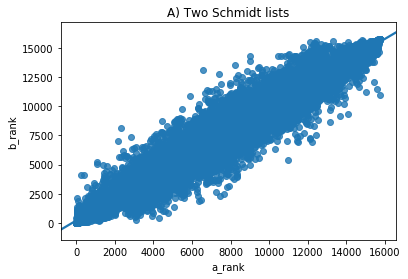

In [11]:
sns.regplot(df['a_rank'], df['b_rank']).set_title("A) Two Schmidt lists")

Text(0.5, 1.0, 'B) Gandal BD vs SCZ')

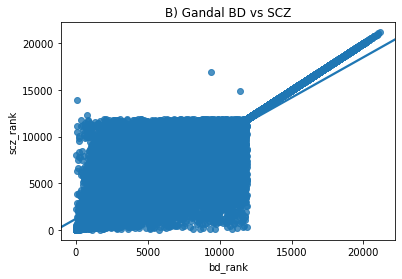

In [12]:
sns.regplot(df['bd_rank'], df['scz_rank']).set_title("B) Gandal BD vs SCZ")

In [13]:
""" Do we have any duplicate gene names? """

df_gandal[df_gandal['gene_name'].duplicated(False)]

,gene_name,asd_fc,asd_p,asd_rank,scz_fc,scz_p,scz_rank,bd_fc,bd_p,bd_rank,mdd_fc,mdd_p,mdd_rank,aad_fc,aad_p,aad_rank,ibd_fc,ibd_p,ibd_rank
entrez_id,,,,,,,,,,,,,,,,,,,
9142,NaN,0.127180,0.053089,4264,0.007356,0.799916,9897,0.047618,0.111634,3312,0.027280,0.367160,9235,0.127550,0.245361,6108,0.015300,2.290236e-01,13566
26148,NaN,0.063817,0.181318,9065,0.028565,0.070771,5260,0.018051,0.444674,7898,0.045664,0.006090,4674,0.041087,0.209394,13191,0.012754,4.598376e-01,14072
79686,NaN,0.136869,0.048829,3775,0.043441,0.182453,3198,0.031823,0.368475,5435,0.070482,0.037861,1570,0.085232,0.146600,8639,0.217644,4.031709e-13,3000
80761,NaN,0.068514,0.466902,8636,0.025097,0.557184,5888,0.022505,0.406302,7021,0.049978,0.344745,3871,0.113442,0.111727,6812,0.024216,2.134500e-01,12052
114299,NaN,0.028040,0.561609,12620,NaN,NaN,15692,NaN,NaN,15694,0.015080,0.645562,13451,0.020827,0.817638,16032,0.079854,1.382685e-06,7218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101930643,NaN,NaN,NaN,21128,NaN,NaN,21131,NaN,NaN,21131,0.022736,0.634220,10718,0.012802,0.773125,17190,0.067200,7.806806e-03,7958
101930651,NaN,NaN,NaN,21129,NaN,NaN,21132,NaN,NaN,21132,0.009837,0.714013,15395,0.071711,0.063466,9795,0.027001,5.894727e-02,11659
101930655,NaN,NaN,NaN,21130,NaN,NaN,21133,NaN,NaN,21133,0.007000,0.795721,16471,NaN,NaN,20845,NaN,NaN,20850


In [14]:
""" Save this dataframe out by either entrez_id or gene_name index. """

df_gandal.to_csv('./gandal_scores_by_entrezid.tsv', sep="\t")
df_gandal.set_index('gene_name').to_csv('./gandal_scores_by_genename.tsv', sep="\t")

In [18]:
print("df_gandal_two has {} entrez_ids with multiple other ids for each.".format(
    len(df_gandal_two.loc[df_gandal_two['entrez_id'].duplicated(False), 'entrez_id'].unique())
))
df_gandal_two.loc[df_gandal_two['entrez_id'].duplicated(False), :].sort_values('entrez_id')


df_gandal_two has 246 entrez_ids with multiple other ids for each.


,entrezgene,ensembl_gene_id,external_gene_id,ASD.beta_log2FC,ASD.P.value,SCZ.beta_log2FC,SCZ.P.value,BD.beta_log2FC,BD.P.value,MDD.beta_log2FC,MDD.P.value,AAD.beta_log2FC,AAD.P.value,IBD.beta_log2FC,IBD.P.value,entrez_id
47,204.0,ENSG00000004455,AK2,0.142090,0.014759,0.055057,0.033750,0.046035,0.166429,-0.020369,0.535408,-0.122761,0.152590,-0.192265,4.168696e-11,204
16888,204.0,ENSG00000185839,RP4-592A1.2,NaN,NaN,-0.009347,0.610209,-0.016098,0.490559,-0.043999,0.086381,NaN,NaN,NaN,NaN,204
17719,578.0,ENSG00000175730,BAK1P1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.188735,0.016131,-0.071182,3.917348e-02,578
16221,578.0,ENSG00000030110,BAK1,NaN,NaN,0.008823,0.638261,0.061676,0.025092,-0.002317,0.930539,NaN,NaN,NaN,NaN,578
17230,629.0,ENSG00000243649,CFB,NaN,NaN,-0.056253,0.124636,-0.018188,0.781530,-0.024608,0.447072,NaN,NaN,NaN,NaN,629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16181,101930578.0,ENSG00000272281,TPTE2P2,0.070402,0.455369,NaN,NaN,NaN,NaN,0.024599,0.287059,0.156747,0.058459,-0.004415,7.446939e-01,101930578
11908,101930591.0,ENSG00000172661,FAM21C,-0.201078,0.016896,-0.033226,0.030744,-0.026807,0.153332,0.013314,0.495522,0.104385,0.157261,-0.130072,1.571461e-03,101930591
23703,101930591.0,ENSG00000099290,FAM21A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034336,0.549966,NaN,NaN,101930591
19899,102464831.0,ENSG00000214176,PLEKHM1P,NaN,NaN,NaN,NaN,NaN,NaN,-0.048100,0.043357,0.049861,0.351748,NaN,NaN,102464831
